In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm import tqdm
import cv2
from skimage import data, io, filters
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
os.getcwd()

'C:\\Users\\avina\\Documents\\MLProject\\Pneumonia'

Now each of the above folder has two subfolders named 'NORMAL' and 'PNEUMONIA'. We need to take images from each of the folders and combine them to form a dataframe that takes the label '0' for Normal and '1' for Pneumonia.

In [18]:
train_data = 'C:\\Users\\avina\\Documents\\MLProject\\Pneumonia\\chest_xray\\chest_xray\\train'
test_data = 'C:\\Users\\avina\\Documents\\MLProject\\Pneumonia\\chest_xray\\chest_xray\\test'
val_data = 'C:\\Users\\avina\\Documents\\MLProject\\Pneumonia\\chest_xray\\chest_xray\\val'

In [10]:
train = []
for img in glob(train_data+'\\PNEUMONIA'+'\\*.jpeg'):
  train.append((img,1))
for img in glob(train_data+'\\'+"NORMAL"+'\\*.jpeg'):
  train.append((img,0))
train_df = pd.DataFrame(train,columns=('Image','Label'),index=None)
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,Image,Label
0,C:\Users\avina\Documents\MLProject\Pneumonia\c...,1
1,C:\Users\avina\Documents\MLProject\Pneumonia\c...,1
2,C:\Users\avina\Documents\MLProject\Pneumonia\c...,1
3,C:\Users\avina\Documents\MLProject\Pneumonia\c...,0
4,C:\Users\avina\Documents\MLProject\Pneumonia\c...,1


In [11]:
train_df.shape

(5216, 2)

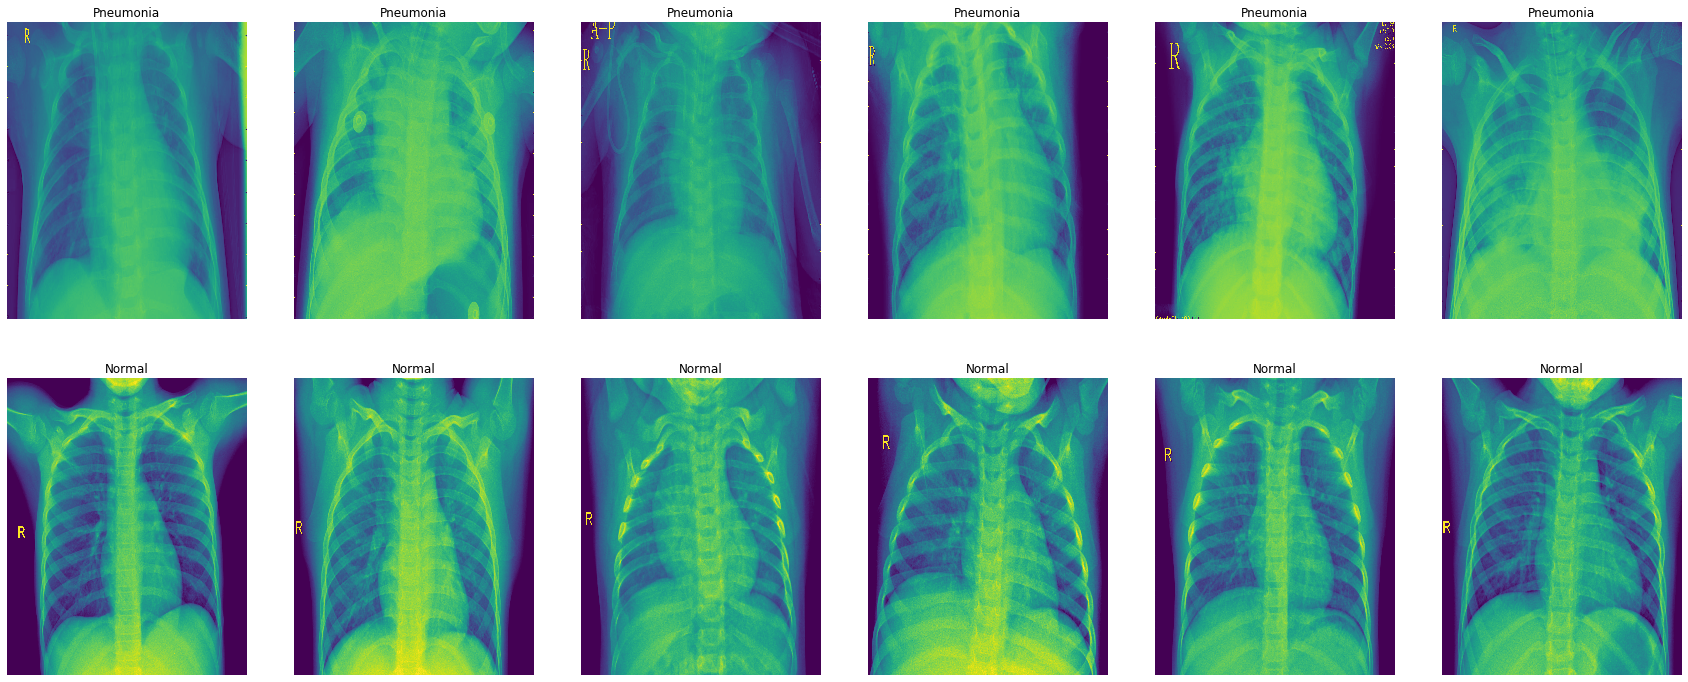

In [12]:
pneumo_sample = (train_df[train_df['Label']==1]['Image'].iloc[:6]).tolist()
normal_sample = (train_df[train_df['Label']==0]['Image'].iloc[:6]).tolist()
combined_sample = pneumo_sample+normal_sample

f,ax = plt.subplots(2,6,figsize=(30,12))
for i in range(12):
    img= imread(combined_sample[i])
    ax[i//6,i%6].imshow(img)
    if i<6:
        ax[i//6, i%6].set_title("Pneumonia")
    else:
        ax[i//6, i%6].set_title("Normal")
    ax[i//6, i%6].axis('off')
    ax[i//6, i%6].set_aspect('auto')
plt.show()


1    3875
0    1341
Name: Label, dtype: int64


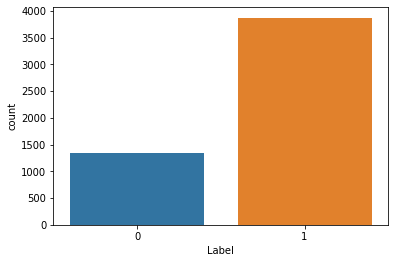

In [13]:
print(train_df['Label'].value_counts())
sns.countplot(x='Label',data=train_df)

In [16]:
"""labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
    
train = get_training_data(train_data)
test = get_training_data(test_data)
val = get_training_data(val_data)

"""

"labels = ['PNEUMONIA', 'NORMAL']\nimg_size = 150\ndef get_training_data(data_dir):\n    data = [] \n    for label in labels: \n        path = os.path.join(data_dir, label)\n        class_num = labels.index(label)\n        for img in tqdm(os.listdir(path)):\n            try:\n                img_arr = cv2.imread(os.path.join(path, img))\n                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size\n                data.append([resized_arr, class_num])\n            except Exception as e:\n                print(e)\n    return np.array(data)\n    \ntrain = get_training_data(train_data)\ntest = get_training_data(test_data)\nval = get_training_data(val_data)\n\n"

In [57]:
""""X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)"""

In [14]:
# Normalize the data
#X_train = np.array(X_train) / 255
#X_val = np.array(X_val) / 255
#X_test = np.array(X_test) / 255

In [15]:
#y_train = to_categorical(y_train,2)
#y_test = to_categorical(y_test,2)
#y_val = to_categorical(y_val,2)

In [17]:
#Using Image Data Generator to extract images from the respective directories. It assigns the labels automatically so you
# dont need to worry about it.
training_generator=ImageDataGenerator(rescale=1/255,featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)
train_generator=training_generator.flow_from_directory(train_data,target_size=(150,150),batch_size=4,class_mode='binary')

Found 5216 images belonging to 2 classes.


In [19]:
validation_generator=ImageDataGenerator(rescale=1/255)
val_generator=validation_generator.flow_from_directory(val_data,target_size=(150,150),batch_size=4,class_mode='binary')

Found 16 images belonging to 2 classes.


In [20]:
test_generator = ImageDataGenerator(rescale=1/255)
test_generator = test_generator.flow_from_directory(test_data,target_size=(150,150),batch_size=4,class_mode='binary')

Found 624 images belonging to 2 classes.


For Finetuning the model we will use Keras callbacks to further finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. We use the callback feature called ReduceLRplatue Models. This feature reduces learning rate by a factor of 2-10 once learning stagnates.This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [21]:
#Creating a call back functionn
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.95):
            print("\n Reaching 95% so stopping the training now")
            self.model.stop_training = True
            
callbacks = myCallback()

In [22]:
filepath = 'weights'
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor = 'val_accuracy', verbose=0, save_freq='epoch',save_best_only=True)

In [23]:
lr_platue = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=5,verbose=0,mode='max')

In [24]:
#Building a Convolutional Model. 
#Its always best practice to use Batch Normalization to make sure the gradients dont vanish at the later layers of the training set

def mymodel(input_shape = (150, 150, 3)):

    
    X_input = tf.keras.layers.Input(input_shape)
    
    # Stage 1
    X = tf.keras.layers.Conv2D(32, (3, 3), padding= 'same', name = 'conv1_a', activation='relu')(X_input) 
    X = tf.keras.layers.MaxPooling2D((2,2),name = 'pool_1')(X)
    
    #Stage 2
    X = tf.keras.layers.Conv2D(64, (3, 3), padding= 'same', name = 'conv2_a', activation='relu')(X) 
    X = tf.keras.layers.BatchNormalization(name = 'bn_conv2_a')(X)
    X = tf.keras.layers.MaxPooling2D((2,2),name = 'pool_2')(X)
    
    X = tf.keras.layers.Dropout(.1, name= "dropout_1")(X)
    
    #Stage 3
    X = tf.keras.layers.Conv2D(128, (3, 3), padding= 'same', name = 'conv3_a', activation='relu')(X)
    X = tf.keras.layers.BatchNormalization(name = 'bn_conv3_a')(X)
    X = tf.keras.layers.MaxPooling2D((2,2), name = 'pool_3')(X)
    
    X = tf.keras.layers.Dropout(.1, name= "dropout_2")(X)

    #Stage 4
    X = tf.keras.layers.Conv2D(256, (3, 3), padding= 'same', name = 'conv4_a', activation='relu')(X)
    X = tf.keras.layers.BatchNormalization(name = 'bn_conv4_a')(X)
    X = tf.keras.layers.MaxPooling2D((2,2), name = 'pool_4')(X)

    X = tf.keras.layers.Dropout(.1, name= "dropout_3")(X)
    
    #Flatten the layers 
    X = tf.keras.layers.Flatten(name='flatten')(X)
    X = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(X)
    X = tf.keras.layers.Dropout(.2, name= "dropout_5")(X)
    X = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_2')(X) 
    
    model = Model(inputs = X_input, outputs= X, name="CNNmodel")
    
    return model

In [25]:
model = mymodel()

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
print(model.summary())

Model: "CNNmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1_a (Conv2D)             (None, 150, 150, 32)      896       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 75, 75, 32)        0         
_________________________________________________________________
conv2_a (Conv2D)             (None, 75, 75, 64)        18496     
_________________________________________________________________
bn_conv2_a (BatchNormalizati (None, 75, 75, 64)        256       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0  

In [35]:
history = model.fit(train_generator,
                    epochs=9,
                    validation_data=val_generator,
                    callbacks=[lr_platue,modelcheckpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1304 steps, validate for 4 steps
Epoch 1/9


 186/1304 [===>..........................] - ETA: 3:40 - loss: 0.2415 - accuracy: 0.75 - ETA: 2:56 - loss: 0.2004 - accuracy: 0.87 - ETA: 2:43 - loss: 0.1441 - accuracy: 0.91 - ETA: 2:34 - loss: 0.1085 - accuracy: 0.93 - ETA: 2:31 - loss: 0.0936 - accuracy: 0.95 - ETA: 2:33 - loss: 0.0825 - accuracy: 0.95 - ETA: 2:32 - loss: 0.0710 - accuracy: 0.96 - ETA: 2:31 - loss: 0.1461 - accuracy: 0.93 - ETA: 2:31 - loss: 0.1302 - accuracy: 0.94 - ETA: 2:28 - loss: 0.1186 - accuracy: 0.95 - ETA: 2:28 - loss: 0.1089 - accuracy: 0.95 - ETA: 2:27 - loss: 0.1123 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1164 - accuracy: 0.96 - ETA: 2:24 - loss: 0.1216 - accuracy: 0.94 - ETA: 2:24 - loss: 0.1135 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1078 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1015 - accuracy: 0.95 - ETA: 2:21 - loss: 0.1078 - accuracy: 0.95 - ETA: 2:21 - loss: 0.1150 - accuracy: 0.94 - ETA: 2:22 - loss: 0.1225 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1169 - accuracy: 0.95 - ETA: 2:21 - loss: 0.1136 - accu

 372/1304 [=======>......................] - ETA: 2:09 - loss: 0.1311 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1342 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1396 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1409 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1404 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1397 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1391 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1399 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1400 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1394 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1388 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1386 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1381 - accuracy: 0.95 - ETA: 2:07 - loss: 0.1374 - accuracy: 0.96 - ETA: 2:07 - loss: 0.1379 - accuracy: 0.96 - ETA: 2:07 - loss: 0.1373 - accuracy: 0.96 - ETA: 2:07 - loss: 0.1372 - accuracy: 0.96 - ETA: 2:07 - loss: 0.1374 - accuracy: 0.96 - ETA: 2:07 - loss: 0.1382 - accuracy: 0.95 - ETA: 2:07 - loss: 0.1394 - accuracy: 0.95 - ETA: 2:07 - loss: 0.1387 - accuracy: 0.95 - ETA: 2:06 - loss: 0.1381 - accu

 558/1304 [===========>..................] - ETA: 1:52 - loss: 0.1598 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1598 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1595 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1592 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1588 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1585 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1582 - accuracy: 0.94 - ETA: 1:52 - loss: 0.1579 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1575 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1571 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1576 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1572 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1575 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1590 - accuracy: 0.94 - ETA: 1:51 - loss: 0.1634 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1636 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1632 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1628 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1628 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1624 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1625 - accuracy: 0.94 - ETA: 1:50 - loss: 0.1620 - accu

 744/1304 [================>.............] - ETA: 1:28 - loss: 0.1531 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1529 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1529 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1560 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1557 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1555 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1552 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1549 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1547 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1546 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1546 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1543 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1555 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1555 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1559 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1558 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1555 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1552 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1550 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1553 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1551 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1550 - accu

 930/1304 [====================>.........] - ETA: 1:06 - loss: 0.1585 - accuracy: 0.95 - ETA: 1:06 - loss: 0.1585 - accuracy: 0.95 - ETA: 1:06 - loss: 0.1586 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1584 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1582 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1580 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1578 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1578 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1580 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1578 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1576 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1576 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1577 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1576 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1575 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1579 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1578 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1576 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1579 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1579 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1579 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1578 - accu

1116/1304 [========================>.....] - ETA: 44s - loss: 0.1610 - accuracy: 0.948 - ETA: 43s - loss: 0.1610 - accuracy: 0.948 - ETA: 43s - loss: 0.1608 - accuracy: 0.948 - ETA: 43s - loss: 0.1615 - accuracy: 0.948 - ETA: 43s - loss: 0.1615 - accuracy: 0.948 - ETA: 43s - loss: 0.1614 - accuracy: 0.948 - ETA: 43s - loss: 0.1613 - accuracy: 0.948 - ETA: 43s - loss: 0.1612 - accuracy: 0.948 - ETA: 43s - loss: 0.1612 - accuracy: 0.948 - ETA: 43s - loss: 0.1612 - accuracy: 0.948 - ETA: 42s - loss: 0.1610 - accuracy: 0.948 - ETA: 42s - loss: 0.1611 - accuracy: 0.948 - ETA: 42s - loss: 0.1612 - accuracy: 0.948 - ETA: 42s - loss: 0.1610 - accuracy: 0.948 - ETA: 42s - loss: 0.1610 - accuracy: 0.948 - ETA: 42s - loss: 0.1609 - accuracy: 0.948 - ETA: 42s - loss: 0.1607 - accuracy: 0.948 - ETA: 42s - loss: 0.1606 - accuracy: 0.948 - ETA: 41s - loss: 0.1604 - accuracy: 0.948 - ETA: 41s - loss: 0.1602 - accuracy: 0.948 - ETA: 41s - loss: 0.1602 - accuracy: 0.948 - ETA: 41s - loss: 0.1600 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1638 - accuracy: 0.946 - ETA: 21s - loss: 0.1638 - accuracy: 0.946 - ETA: 21s - loss: 0.1636 - accuracy: 0.946 - ETA: 21s - loss: 0.1636 - accuracy: 0.946 - ETA: 21s - loss: 0.1635 - accuracy: 0.946 - ETA: 21s - loss: 0.1633 - accuracy: 0.947 - ETA: 21s - loss: 0.1633 - accuracy: 0.947 - ETA: 21s - loss: 0.1632 - accuracy: 0.947 - ETA: 21s - loss: 0.1634 - accuracy: 0.946 - ETA: 20s - loss: 0.1633 - accuracy: 0.946 - ETA: 20s - loss: 0.1632 - accuracy: 0.947 - ETA: 20s - loss: 0.1631 - accuracy: 0.947 - ETA: 20s - loss: 0.1630 - accuracy: 0.947 - ETA: 20s - loss: 0.1629 - accuracy: 0.947 - ETA: 20s - loss: 0.1628 - accuracy: 0.947 - ETA: 20s - loss: 0.1627 - accuracy: 0.947 - ETA: 20s - loss: 0.1626 - accuracy: 0.947 - ETA: 20s - loss: 0.1625 - accuracy: 0.947 - ETA: 19s - loss: 0.1624 - accuracy: 0.947 - ETA: 19s - loss: 0.1622 - accuracy: 0.947 - ETA: 19s - loss: 0.1622 - accuracy: 0.947 - ETA: 19s - loss: 0.1623 - accur

Epoch 2/9


 185/1304 [===>..........................] - ETA: 3:35 - loss: 0.1518 - accuracy: 1.00 - ETA: 3:03 - loss: 0.0788 - accuracy: 1.00 - ETA: 3:07 - loss: 0.1421 - accuracy: 0.91 - ETA: 3:06 - loss: 0.1969 - accuracy: 0.87 - ETA: 2:57 - loss: 0.2060 - accuracy: 0.90 - ETA: 2:50 - loss: 0.2192 - accuracy: 0.87 - ETA: 2:45 - loss: 0.1941 - accuracy: 0.89 - ETA: 2:41 - loss: 0.1699 - accuracy: 0.90 - ETA: 2:38 - loss: 0.1765 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3058 - accuracy: 0.87 - ETA: 2:35 - loss: 0.2960 - accuracy: 0.86 - ETA: 2:37 - loss: 0.2762 - accuracy: 0.87 - ETA: 2:36 - loss: 0.2816 - accuracy: 0.86 - ETA: 2:37 - loss: 0.2702 - accuracy: 0.87 - ETA: 2:37 - loss: 0.2624 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2484 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2362 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2336 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2265 - accuracy: 0.89 - ETA: 2:34 - loss: 0.2160 - accuracy: 0.90 - ETA: 2:33 - loss: 0.2057 - accuracy: 0.90 - ETA: 2:32 - loss: 0.2004 - accu

 371/1304 [=======>......................] - ETA: 2:10 - loss: 0.1900 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1903 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1895 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1894 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1884 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1876 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1866 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1858 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1861 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1852 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1842 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1834 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1837 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1828 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1823 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1814 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1805 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1846 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1839 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1830 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1824 - accuracy: 0.94 - ETA: 2:07 - loss: 0.1825 - accu

 557/1304 [===========>..................] - ETA: 1:48 - loss: 0.1537 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1533 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1530 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1526 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1522 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1518 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1515 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1512 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1521 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1518 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1516 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1512 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1508 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1514 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1510 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1506 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1504 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1500 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1504 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1502 - accuracy: 0.94 - ETA: 1:45 - loss: 0.1499 - accuracy: 0.94 - ETA: 1:45 - loss: 0.1495 - accu

 743/1304 [================>.............] - ETA: 1:27 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1423 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1422 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1420 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1415 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1412 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1417 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1415 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1413 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1406 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1405 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1412 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1409 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1404 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1406 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1404 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1403 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1401 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1400 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1430 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1428 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1427 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1439 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1443 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1441 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1439 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1434 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1433 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1431 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1430 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1419 - accuracy: 0.948 - ETA: 43s - loss: 0.1417 - accuracy: 0.948 - ETA: 43s - loss: 0.1417 - accuracy: 0.948 - ETA: 43s - loss: 0.1415 - accuracy: 0.948 - ETA: 43s - loss: 0.1414 - accuracy: 0.948 - ETA: 43s - loss: 0.1413 - accuracy: 0.948 - ETA: 43s - loss: 0.1417 - accuracy: 0.948 - ETA: 43s - loss: 0.1418 - accuracy: 0.948 - ETA: 42s - loss: 0.1418 - accuracy: 0.948 - ETA: 42s - loss: 0.1422 - accuracy: 0.947 - ETA: 42s - loss: 0.1420 - accuracy: 0.947 - ETA: 42s - loss: 0.1424 - accuracy: 0.947 - ETA: 42s - loss: 0.1423 - accuracy: 0.947 - ETA: 42s - loss: 0.1421 - accuracy: 0.947 - ETA: 42s - loss: 0.1421 - accuracy: 0.947 - ETA: 42s - loss: 0.1419 - accuracy: 0.947 - ETA: 41s - loss: 0.1418 - accuracy: 0.947 - ETA: 41s - loss: 0.1417 - accuracy: 0.948 - ETA: 41s - loss: 0.1417 - accuracy: 0.948 - ETA: 41s - loss: 0.1418 - accuracy: 0.948 - ETA: 41s - loss: 0.1418 - accuracy: 0.948 - ETA: 41s - loss: 0.1417 - accur

1304/1304 [==============================] - ETA: 21s - loss: 0.1391 - accuracy: 0.948 - ETA: 21s - loss: 0.1392 - accuracy: 0.948 - ETA: 21s - loss: 0.1391 - accuracy: 0.948 - ETA: 21s - loss: 0.1390 - accuracy: 0.948 - ETA: 21s - loss: 0.1390 - accuracy: 0.948 - ETA: 21s - loss: 0.1390 - accuracy: 0.948 - ETA: 21s - loss: 0.1390 - accuracy: 0.949 - ETA: 21s - loss: 0.1388 - accuracy: 0.949 - ETA: 21s - loss: 0.1399 - accuracy: 0.948 - ETA: 20s - loss: 0.1397 - accuracy: 0.948 - ETA: 20s - loss: 0.1396 - accuracy: 0.948 - ETA: 20s - loss: 0.1395 - accuracy: 0.948 - ETA: 20s - loss: 0.1394 - accuracy: 0.948 - ETA: 20s - loss: 0.1393 - accuracy: 0.948 - ETA: 20s - loss: 0.1398 - accuracy: 0.948 - ETA: 20s - loss: 0.1403 - accuracy: 0.948 - ETA: 20s - loss: 0.1402 - accuracy: 0.948 - ETA: 19s - loss: 0.1402 - accuracy: 0.948 - ETA: 19s - loss: 0.1405 - accuracy: 0.948 - ETA: 19s - loss: 0.1404 - accuracy: 0.948 - ETA: 19s - loss: 0.1407 - accuracy: 0.948 - ETA: 19s - loss: 0.1408 - accur

Epoch 3/9


 185/1304 [===>..........................] - ETA: 3:50 - loss: 0.0571 - accuracy: 1.00 - ETA: 3:05 - loss: 0.0408 - accuracy: 1.00 - ETA: 3:11 - loss: 0.0612 - accuracy: 1.00 - ETA: 2:59 - loss: 0.0535 - accuracy: 1.00 - ETA: 2:50 - loss: 0.0749 - accuracy: 1.00 - ETA: 2:46 - loss: 0.0843 - accuracy: 1.00 - ETA: 2:48 - loss: 0.0747 - accuracy: 1.00 - ETA: 2:45 - loss: 0.0760 - accuracy: 1.00 - ETA: 2:45 - loss: 0.0745 - accuracy: 1.00 - ETA: 2:49 - loss: 0.0804 - accuracy: 1.00 - ETA: 2:46 - loss: 0.0734 - accuracy: 1.00 - ETA: 2:45 - loss: 0.0774 - accuracy: 1.00 - ETA: 2:43 - loss: 0.0714 - accuracy: 1.00 - ETA: 2:44 - loss: 0.0667 - accuracy: 1.00 - ETA: 2:42 - loss: 0.0623 - accuracy: 1.00 - ETA: 2:40 - loss: 0.0849 - accuracy: 0.98 - ETA: 2:41 - loss: 0.0800 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0755 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0716 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0680 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0659 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0644 - accu

 371/1304 [=======>......................] - ETA: 2:13 - loss: 0.1728 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1718 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1709 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1702 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1694 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1696 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1687 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1681 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1677 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1668 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1665 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1657 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1657 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1660 - accuracy: 0.94 - ETA: 2:12 - loss: 0.1653 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1661 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1654 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1646 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1639 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1631 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1624 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1616 - accu

 557/1304 [===========>..................] - ETA: 1:49 - loss: 0.1607 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1619 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1618 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1619 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1616 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1612 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1610 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1607 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1603 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1599 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1595 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1595 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1594 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1593 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1590 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1594 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1595 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1595 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1591 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1591 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1587 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1587 - accu

 743/1304 [================>.............] - ETA: 1:27 - loss: 0.1583 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1582 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1580 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1581 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1586 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1584 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1582 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1579 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1584 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1583 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1581 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1581 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1578 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1577 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1582 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1584 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1587 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1584 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1582 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1581 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1584 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1582 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1632 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1638 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1636 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1634 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1632 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1630 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1628 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1628 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1629 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1629 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1627 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1625 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1623 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1623 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1623 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1621 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1647 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1648 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1647 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1645 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1643 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1647 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1680 - accuracy: 0.943 - ETA: 43s - loss: 0.1683 - accuracy: 0.943 - ETA: 43s - loss: 0.1682 - accuracy: 0.943 - ETA: 43s - loss: 0.1680 - accuracy: 0.943 - ETA: 43s - loss: 0.1679 - accuracy: 0.943 - ETA: 43s - loss: 0.1678 - accuracy: 0.943 - ETA: 43s - loss: 0.1679 - accuracy: 0.943 - ETA: 43s - loss: 0.1678 - accuracy: 0.943 - ETA: 42s - loss: 0.1677 - accuracy: 0.943 - ETA: 42s - loss: 0.1675 - accuracy: 0.943 - ETA: 42s - loss: 0.1674 - accuracy: 0.943 - ETA: 42s - loss: 0.1674 - accuracy: 0.943 - ETA: 42s - loss: 0.1672 - accuracy: 0.943 - ETA: 42s - loss: 0.1671 - accuracy: 0.943 - ETA: 42s - loss: 0.1671 - accuracy: 0.943 - ETA: 42s - loss: 0.1671 - accuracy: 0.943 - ETA: 41s - loss: 0.1672 - accuracy: 0.943 - ETA: 41s - loss: 0.1676 - accuracy: 0.943 - ETA: 41s - loss: 0.1676 - accuracy: 0.943 - ETA: 41s - loss: 0.1675 - accuracy: 0.943 - ETA: 41s - loss: 0.1673 - accuracy: 0.943 - ETA: 41s - loss: 0.1672 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1616 - accuracy: 0.944 - ETA: 21s - loss: 0.1619 - accuracy: 0.944 - ETA: 21s - loss: 0.1618 - accuracy: 0.944 - ETA: 21s - loss: 0.1616 - accuracy: 0.944 - ETA: 21s - loss: 0.1615 - accuracy: 0.944 - ETA: 21s - loss: 0.1614 - accuracy: 0.944 - ETA: 21s - loss: 0.1613 - accuracy: 0.945 - ETA: 21s - loss: 0.1611 - accuracy: 0.945 - ETA: 21s - loss: 0.1610 - accuracy: 0.945 - ETA: 20s - loss: 0.1610 - accuracy: 0.945 - ETA: 20s - loss: 0.1608 - accuracy: 0.945 - ETA: 20s - loss: 0.1607 - accuracy: 0.945 - ETA: 20s - loss: 0.1607 - accuracy: 0.945 - ETA: 20s - loss: 0.1609 - accuracy: 0.945 - ETA: 20s - loss: 0.1607 - accuracy: 0.945 - ETA: 20s - loss: 0.1606 - accuracy: 0.945 - ETA: 20s - loss: 0.1606 - accuracy: 0.945 - ETA: 20s - loss: 0.1605 - accuracy: 0.945 - ETA: 19s - loss: 0.1604 - accuracy: 0.945 - ETA: 19s - loss: 0.1603 - accuracy: 0.945 - ETA: 19s - loss: 0.1603 - accuracy: 0.945 - ETA: 19s - loss: 0.1602 - accur

Epoch 4/9


 185/1304 [===>..........................] - ETA: 4:14 - loss: 0.0085 - accuracy: 1.00 - ETA: 3:17 - loss: 0.0091 - accuracy: 1.00 - ETA: 2:58 - loss: 0.0609 - accuracy: 1.00 - ETA: 2:49 - loss: 0.1946 - accuracy: 0.93 - ETA: 2:45 - loss: 0.3287 - accuracy: 0.90 - ETA: 2:42 - loss: 0.2747 - accuracy: 0.91 - ETA: 2:44 - loss: 0.3025 - accuracy: 0.89 - ETA: 2:42 - loss: 0.2662 - accuracy: 0.90 - ETA: 2:44 - loss: 0.3113 - accuracy: 0.86 - ETA: 2:42 - loss: 0.2809 - accuracy: 0.87 - ETA: 2:40 - loss: 0.2611 - accuracy: 0.88 - ETA: 2:39 - loss: 0.2395 - accuracy: 0.89 - ETA: 2:38 - loss: 0.2214 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2164 - accuracy: 0.91 - ETA: 2:36 - loss: 0.2058 - accuracy: 0.91 - ETA: 2:35 - loss: 0.1984 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1976 - accuracy: 0.91 - ETA: 2:37 - loss: 0.1922 - accuracy: 0.91 - ETA: 2:37 - loss: 0.1872 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1784 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1703 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1661 - accu

 371/1304 [=======>......................] - ETA: 2:11 - loss: 0.1580 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1577 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1570 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1572 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1564 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1579 - accuracy: 0.93 - ETA: 2:11 - loss: 0.1572 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1562 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1558 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1551 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1545 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1552 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1545 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1537 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1530 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1522 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1515 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1523 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1517 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1522 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1520 - accu

 557/1304 [===========>..................] - ETA: 1:49 - loss: 0.1634 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1630 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1626 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1628 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1624 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1621 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1636 - accuracy: 0.93 - ETA: 1:48 - loss: 0.1632 - accuracy: 0.93 - ETA: 1:48 - loss: 0.1633 - accuracy: 0.93 - ETA: 1:48 - loss: 0.1632 - accuracy: 0.93 - ETA: 1:48 - loss: 0.1628 - accuracy: 0.93 - ETA: 1:48 - loss: 0.1629 - accuracy: 0.93 - ETA: 1:48 - loss: 0.1626 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1623 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1651 - accuracy: 0.93 - ETA: 1:47 - loss: 0.1646 - accuracy: 0.93 - ETA: 1:47 - loss: 0.1643 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1645 - accuracy: 0.93 - ETA: 1:47 - loss: 0.1641 - accuracy: 0.93 - ETA: 1:47 - loss: 0.1653 - accuracy: 0.93 - ETA: 1:47 - loss: 0.1669 - accuracy: 0.93 - ETA: 1:46 - loss: 0.1671 - accu

 743/1304 [================>.............] - ETA: 1:27 - loss: 0.1602 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1599 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1597 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1612 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1610 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1607 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1635 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1653 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1650 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1648 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1645 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1644 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1641 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1638 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1636 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1633 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1633 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1631 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1628 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1634 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1631 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1630 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1550 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1548 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1547 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1546 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1545 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1545 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1545 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1559 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1557 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1556 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1556 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1558 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1556 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1554 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1553 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1551 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1549 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1547 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1545 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1559 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1560 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1559 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1518 - accuracy: 0.944 - ETA: 43s - loss: 0.1520 - accuracy: 0.944 - ETA: 43s - loss: 0.1518 - accuracy: 0.944 - ETA: 43s - loss: 0.1518 - accuracy: 0.944 - ETA: 43s - loss: 0.1518 - accuracy: 0.944 - ETA: 43s - loss: 0.1517 - accuracy: 0.944 - ETA: 42s - loss: 0.1521 - accuracy: 0.944 - ETA: 42s - loss: 0.1527 - accuracy: 0.944 - ETA: 42s - loss: 0.1576 - accuracy: 0.944 - ETA: 42s - loss: 0.1578 - accuracy: 0.943 - ETA: 42s - loss: 0.1577 - accuracy: 0.943 - ETA: 42s - loss: 0.1576 - accuracy: 0.943 - ETA: 42s - loss: 0.1574 - accuracy: 0.944 - ETA: 42s - loss: 0.1573 - accuracy: 0.944 - ETA: 42s - loss: 0.1572 - accuracy: 0.944 - ETA: 41s - loss: 0.1571 - accuracy: 0.944 - ETA: 41s - loss: 0.1570 - accuracy: 0.944 - ETA: 41s - loss: 0.1570 - accuracy: 0.944 - ETA: 41s - loss: 0.1568 - accuracy: 0.944 - ETA: 41s - loss: 0.1569 - accuracy: 0.944 - ETA: 41s - loss: 0.1570 - accuracy: 0.943 - ETA: 41s - loss: 0.1570 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1605 - accuracy: 0.944 - ETA: 21s - loss: 0.1604 - accuracy: 0.944 - ETA: 21s - loss: 0.1603 - accuracy: 0.945 - ETA: 21s - loss: 0.1603 - accuracy: 0.945 - ETA: 21s - loss: 0.1602 - accuracy: 0.945 - ETA: 21s - loss: 0.1603 - accuracy: 0.945 - ETA: 21s - loss: 0.1619 - accuracy: 0.945 - ETA: 21s - loss: 0.1618 - accuracy: 0.945 - ETA: 21s - loss: 0.1618 - accuracy: 0.945 - ETA: 20s - loss: 0.1617 - accuracy: 0.945 - ETA: 20s - loss: 0.1615 - accuracy: 0.945 - ETA: 20s - loss: 0.1614 - accuracy: 0.945 - ETA: 20s - loss: 0.1615 - accuracy: 0.945 - ETA: 20s - loss: 0.1614 - accuracy: 0.945 - ETA: 20s - loss: 0.1612 - accuracy: 0.945 - ETA: 20s - loss: 0.1618 - accuracy: 0.945 - ETA: 20s - loss: 0.1617 - accuracy: 0.945 - ETA: 20s - loss: 0.1616 - accuracy: 0.945 - ETA: 19s - loss: 0.1615 - accuracy: 0.945 - ETA: 19s - loss: 0.1613 - accuracy: 0.945 - ETA: 19s - loss: 0.1612 - accuracy: 0.945 - ETA: 19s - loss: 0.1611 - accur

Epoch 5/9


 185/1304 [===>..........................] - ETA: 4:03 - loss: 0.4059 - accuracy: 0.75 - ETA: 3:11 - loss: 0.2034 - accuracy: 0.87 - ETA: 2:59 - loss: 0.1380 - accuracy: 0.91 - ETA: 2:49 - loss: 0.1044 - accuracy: 0.93 - ETA: 2:52 - loss: 0.0877 - accuracy: 0.95 - ETA: 2:47 - loss: 0.0882 - accuracy: 0.95 - ETA: 2:44 - loss: 0.0757 - accuracy: 0.96 - ETA: 2:41 - loss: 0.0662 - accuracy: 0.96 - ETA: 2:41 - loss: 0.0766 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0690 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0621 - accuracy: 0.97 - ETA: 2:33 - loss: 0.0576 - accuracy: 0.98 - ETA: 2:33 - loss: 0.0535 - accuracy: 0.98 - ETA: 2:33 - loss: 0.0511 - accuracy: 0.98 - ETA: 2:32 - loss: 0.0536 - accuracy: 0.98 - ETA: 2:33 - loss: 0.1262 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1216 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1156 - accuracy: 0.96 - ETA: 2:30 - loss: 0.1394 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1334 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1274 - accu

 371/1304 [=======>......................] - ETA: 2:12 - loss: 0.1474 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1459 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1451 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1446 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1438 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1431 - accuracy: 0.94 - ETA: 2:11 - loss: 0.1424 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1419 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1412 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1405 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1398 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1384 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1377 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1448 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1445 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1438 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1431 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1424 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1418 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1411 - accu

 557/1304 [===========>..................] - ETA: 1:49 - loss: 0.1355 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1352 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1353 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1350 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1348 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1346 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1348 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1347 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1344 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1342 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1344 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1341 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1338 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1335 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1335 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1333 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1332 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1334 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1331 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1328 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1325 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1358 - accu

 743/1304 [================>.............] - ETA: 1:26 - loss: 0.1428 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1424 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1422 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1421 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1424 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1423 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1430 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1428 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1423 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1421 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1423 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1421 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1419 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1424 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1418 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1413 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1413 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1415 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1416 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1415 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1413 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1412 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1408 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1406 - accuracy: 0.94 - ETA: 1:02 - loss: 0.1404 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1349 - accuracy: 0.951 - ETA: 43s - loss: 0.1361 - accuracy: 0.951 - ETA: 43s - loss: 0.1362 - accuracy: 0.951 - ETA: 43s - loss: 0.1360 - accuracy: 0.951 - ETA: 43s - loss: 0.1359 - accuracy: 0.951 - ETA: 43s - loss: 0.1358 - accuracy: 0.951 - ETA: 42s - loss: 0.1358 - accuracy: 0.951 - ETA: 42s - loss: 0.1372 - accuracy: 0.951 - ETA: 42s - loss: 0.1371 - accuracy: 0.951 - ETA: 42s - loss: 0.1370 - accuracy: 0.951 - ETA: 42s - loss: 0.1372 - accuracy: 0.951 - ETA: 42s - loss: 0.1371 - accuracy: 0.951 - ETA: 42s - loss: 0.1374 - accuracy: 0.950 - ETA: 42s - loss: 0.1375 - accuracy: 0.951 - ETA: 42s - loss: 0.1376 - accuracy: 0.950 - ETA: 41s - loss: 0.1375 - accuracy: 0.950 - ETA: 41s - loss: 0.1374 - accuracy: 0.950 - ETA: 41s - loss: 0.1372 - accuracy: 0.950 - ETA: 41s - loss: 0.1372 - accuracy: 0.950 - ETA: 41s - loss: 0.1373 - accuracy: 0.950 - ETA: 41s - loss: 0.1372 - accuracy: 0.950 - ETA: 41s - loss: 0.1372 - accur

1304/1304 [==============================] - ETA: 21s - loss: 0.1418 - accuracy: 0.947 - ETA: 21s - loss: 0.1417 - accuracy: 0.947 - ETA: 21s - loss: 0.1416 - accuracy: 0.947 - ETA: 21s - loss: 0.1417 - accuracy: 0.947 - ETA: 21s - loss: 0.1421 - accuracy: 0.947 - ETA: 21s - loss: 0.1420 - accuracy: 0.947 - ETA: 21s - loss: 0.1419 - accuracy: 0.947 - ETA: 21s - loss: 0.1417 - accuracy: 0.947 - ETA: 21s - loss: 0.1416 - accuracy: 0.948 - ETA: 20s - loss: 0.1419 - accuracy: 0.947 - ETA: 20s - loss: 0.1418 - accuracy: 0.947 - ETA: 20s - loss: 0.1417 - accuracy: 0.947 - ETA: 20s - loss: 0.1416 - accuracy: 0.947 - ETA: 20s - loss: 0.1415 - accuracy: 0.948 - ETA: 20s - loss: 0.1413 - accuracy: 0.948 - ETA: 20s - loss: 0.1417 - accuracy: 0.947 - ETA: 20s - loss: 0.1416 - accuracy: 0.947 - ETA: 19s - loss: 0.1415 - accuracy: 0.947 - ETA: 19s - loss: 0.1414 - accuracy: 0.948 - ETA: 19s - loss: 0.1413 - accuracy: 0.948 - ETA: 19s - loss: 0.1413 - accuracy: 0.948 - ETA: 19s - loss: 0.1413 - accur

Epoch 6/9


 185/1304 [===>..........................] - ETA: 3:14 - loss: 0.0761 - accuracy: 1.00 - ETA: 2:50 - loss: 0.0427 - accuracy: 1.00 - ETA: 2:39 - loss: 0.0507 - accuracy: 1.00 - ETA: 2:37 - loss: 0.0971 - accuracy: 0.93 - ETA: 2:39 - loss: 0.0779 - accuracy: 0.95 - ETA: 2:35 - loss: 0.0657 - accuracy: 0.95 - ETA: 2:35 - loss: 0.0787 - accuracy: 0.96 - ETA: 2:32 - loss: 0.1429 - accuracy: 0.93 - ETA: 2:30 - loss: 0.1309 - accuracy: 0.94 - ETA: 2:29 - loss: 0.1865 - accuracy: 0.92 - ETA: 2:28 - loss: 0.1701 - accuracy: 0.93 - ETA: 2:30 - loss: 0.1688 - accuracy: 0.93 - ETA: 2:33 - loss: 0.1717 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1600 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1563 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:35 - loss: 0.1499 - accuracy: 0.94 - ETA: 2:34 - loss: 0.1416 - accuracy: 0.94 - ETA: 2:34 - loss: 0.1435 - accuracy: 0.93 - ETA: 2:32 - loss: 0.1364 - accuracy: 0.93 - ETA: 2:31 - loss: 0.1456 - accuracy: 0.94 - ETA: 2:31 - loss: 0.1391 - accu

 371/1304 [=======>......................] - ETA: 2:10 - loss: 0.1118 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1113 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1111 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1105 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1099 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1094 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1088 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1083 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1082 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1078 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1073 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1082 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1077 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1073 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1134 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1129 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1129 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1124 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1122 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1120 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1162 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1157 - accu

 557/1304 [===========>..................] - ETA: 1:49 - loss: 0.1290 - accuracy: 0.95 - ETA: 1:49 - loss: 0.1294 - accuracy: 0.95 - ETA: 1:49 - loss: 0.1293 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1330 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1327 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1323 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1320 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1319 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1322 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1318 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1315 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1315 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1312 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1311 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1312 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1310 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1306 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1304 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1301 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1305 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1332 - accuracy: 0.95 - ETA: 1:46 - loss: 0.1328 - accu

 743/1304 [================>.............] - ETA: 1:27 - loss: 0.1396 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1399 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1398 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1401 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1404 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1402 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1400 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1403 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1401 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1399 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1409 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1408 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1405 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1403 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1405 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1415 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1412 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1416 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1386 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1385 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1384 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1382 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1382 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1380 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1381 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1379 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1378 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1377 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1398 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1398 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1397 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1414 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1412 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1410 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1413 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1411 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1411 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1376 - accuracy: 0.949 - ETA: 43s - loss: 0.1374 - accuracy: 0.949 - ETA: 43s - loss: 0.1373 - accuracy: 0.949 - ETA: 43s - loss: 0.1375 - accuracy: 0.949 - ETA: 43s - loss: 0.1374 - accuracy: 0.949 - ETA: 43s - loss: 0.1372 - accuracy: 0.949 - ETA: 43s - loss: 0.1372 - accuracy: 0.949 - ETA: 42s - loss: 0.1372 - accuracy: 0.949 - ETA: 42s - loss: 0.1372 - accuracy: 0.949 - ETA: 42s - loss: 0.1379 - accuracy: 0.949 - ETA: 42s - loss: 0.1378 - accuracy: 0.949 - ETA: 42s - loss: 0.1381 - accuracy: 0.949 - ETA: 42s - loss: 0.1381 - accuracy: 0.949 - ETA: 42s - loss: 0.1379 - accuracy: 0.949 - ETA: 42s - loss: 0.1385 - accuracy: 0.949 - ETA: 42s - loss: 0.1384 - accuracy: 0.949 - ETA: 41s - loss: 0.1382 - accuracy: 0.949 - ETA: 41s - loss: 0.1382 - accuracy: 0.949 - ETA: 41s - loss: 0.1380 - accuracy: 0.949 - ETA: 41s - loss: 0.1382 - accuracy: 0.949 - ETA: 41s - loss: 0.1380 - accuracy: 0.949 - ETA: 41s - loss: 0.1382 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1401 - accuracy: 0.947 - ETA: 21s - loss: 0.1401 - accuracy: 0.947 - ETA: 21s - loss: 0.1400 - accuracy: 0.947 - ETA: 21s - loss: 0.1400 - accuracy: 0.947 - ETA: 21s - loss: 0.1399 - accuracy: 0.947 - ETA: 21s - loss: 0.1398 - accuracy: 0.947 - ETA: 21s - loss: 0.1406 - accuracy: 0.947 - ETA: 21s - loss: 0.1405 - accuracy: 0.947 - ETA: 21s - loss: 0.1404 - accuracy: 0.947 - ETA: 21s - loss: 0.1403 - accuracy: 0.947 - ETA: 20s - loss: 0.1402 - accuracy: 0.947 - ETA: 20s - loss: 0.1405 - accuracy: 0.947 - ETA: 20s - loss: 0.1405 - accuracy: 0.947 - ETA: 20s - loss: 0.1408 - accuracy: 0.946 - ETA: 20s - loss: 0.1407 - accuracy: 0.946 - ETA: 20s - loss: 0.1406 - accuracy: 0.946 - ETA: 20s - loss: 0.1408 - accuracy: 0.946 - ETA: 20s - loss: 0.1409 - accuracy: 0.946 - ETA: 19s - loss: 0.1408 - accuracy: 0.946 - ETA: 19s - loss: 0.1407 - accuracy: 0.946 - ETA: 19s - loss: 0.1408 - accuracy: 0.946 - ETA: 19s - loss: 0.1408 - accur

Epoch 7/9


 185/1304 [===>..........................] - ETA: 3:38 - loss: 0.0285 - accuracy: 1.00 - ETA: 2:55 - loss: 0.0959 - accuracy: 1.00 - ETA: 2:43 - loss: 0.0640 - accuracy: 1.00 - ETA: 2:41 - loss: 0.0545 - accuracy: 1.00 - ETA: 2:36 - loss: 0.0510 - accuracy: 1.00 - ETA: 2:36 - loss: 0.0510 - accuracy: 1.00 - ETA: 2:37 - loss: 0.1176 - accuracy: 0.96 - ETA: 2:35 - loss: 0.1620 - accuracy: 0.93 - ETA: 2:34 - loss: 0.1491 - accuracy: 0.94 - ETA: 2:34 - loss: 0.1360 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1342 - accuracy: 0.95 - ETA: 2:34 - loss: 0.1408 - accuracy: 0.93 - ETA: 2:32 - loss: 0.1299 - accuracy: 0.94 - ETA: 2:31 - loss: 0.1213 - accuracy: 0.94 - ETA: 2:31 - loss: 0.1144 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1304 - accuracy: 0.93 - ETA: 2:30 - loss: 0.1228 - accuracy: 0.94 - ETA: 2:29 - loss: 0.1660 - accuracy: 0.93 - ETA: 2:30 - loss: 0.1587 - accuracy: 0.93 - ETA: 2:30 - loss: 0.1508 - accuracy: 0.93 - ETA: 2:29 - loss: 0.1476 - accuracy: 0.94 - ETA: 2:31 - loss: 0.1527 - accu

 371/1304 [=======>......................] - ETA: 2:11 - loss: 0.1108 - accuracy: 0.95 - ETA: 2:11 - loss: 0.1145 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1147 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1176 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1234 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1232 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1231 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1236 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1319 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1383 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1393 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1408 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1404 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1399 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1400 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1440 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1435 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1432 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1431 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1429 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1433 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1427 - accu

 557/1304 [===========>..................] - ETA: 1:49 - loss: 0.1528 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1524 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1520 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1516 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1541 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1538 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1537 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1534 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1530 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1526 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1526 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1533 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1529 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1526 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1531 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1528 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1527 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1523 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1519 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1516 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1533 - accuracy: 0.94 - ETA: 1:46 - loss: 0.1534 - accu

 743/1304 [================>.............] - ETA: 1:27 - loss: 0.1409 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1406 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1404 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1414 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1412 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1440 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1435 - accuracy: 0.95 - ETA: 1:26 - loss: 0.1443 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1440 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1434 - accuracy: 0.95 - ETA: 1:25 - loss: 0.1432 - accuracy: 0.95 - ETA: 1:25 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1441 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1434 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1432 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1430 - accuracy: 0.94 - ETA: 1:24 - loss: 0.1428 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1458 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1456 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1457 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1457 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1455 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1456 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1454 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1452 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1451 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1450 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1448 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1446 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1445 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1451 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1449 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1449 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1448 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1446 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1441 - accuracy: 0.950 - ETA: 43s - loss: 0.1439 - accuracy: 0.950 - ETA: 43s - loss: 0.1440 - accuracy: 0.949 - ETA: 43s - loss: 0.1439 - accuracy: 0.949 - ETA: 43s - loss: 0.1438 - accuracy: 0.949 - ETA: 43s - loss: 0.1436 - accuracy: 0.950 - ETA: 43s - loss: 0.1435 - accuracy: 0.950 - ETA: 43s - loss: 0.1434 - accuracy: 0.950 - ETA: 42s - loss: 0.1434 - accuracy: 0.950 - ETA: 42s - loss: 0.1432 - accuracy: 0.950 - ETA: 42s - loss: 0.1442 - accuracy: 0.950 - ETA: 42s - loss: 0.1441 - accuracy: 0.950 - ETA: 42s - loss: 0.1439 - accuracy: 0.950 - ETA: 42s - loss: 0.1437 - accuracy: 0.950 - ETA: 42s - loss: 0.1436 - accuracy: 0.950 - ETA: 42s - loss: 0.1435 - accuracy: 0.950 - ETA: 41s - loss: 0.1434 - accuracy: 0.950 - ETA: 41s - loss: 0.1432 - accuracy: 0.950 - ETA: 41s - loss: 0.1431 - accuracy: 0.950 - ETA: 41s - loss: 0.1430 - accuracy: 0.950 - ETA: 41s - loss: 0.1437 - accuracy: 0.950 - ETA: 41s - loss: 0.1446 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1510 - accuracy: 0.945 - ETA: 21s - loss: 0.1518 - accuracy: 0.945 - ETA: 21s - loss: 0.1518 - accuracy: 0.945 - ETA: 21s - loss: 0.1523 - accuracy: 0.945 - ETA: 21s - loss: 0.1522 - accuracy: 0.945 - ETA: 21s - loss: 0.1522 - accuracy: 0.945 - ETA: 21s - loss: 0.1525 - accuracy: 0.945 - ETA: 21s - loss: 0.1524 - accuracy: 0.945 - ETA: 21s - loss: 0.1528 - accuracy: 0.945 - ETA: 21s - loss: 0.1527 - accuracy: 0.945 - ETA: 20s - loss: 0.1526 - accuracy: 0.945 - ETA: 20s - loss: 0.1526 - accuracy: 0.945 - ETA: 20s - loss: 0.1525 - accuracy: 0.945 - ETA: 20s - loss: 0.1525 - accuracy: 0.944 - ETA: 20s - loss: 0.1525 - accuracy: 0.944 - ETA: 20s - loss: 0.1524 - accuracy: 0.945 - ETA: 20s - loss: 0.1524 - accuracy: 0.945 - ETA: 20s - loss: 0.1522 - accuracy: 0.945 - ETA: 19s - loss: 0.1522 - accuracy: 0.945 - ETA: 19s - loss: 0.1521 - accuracy: 0.945 - ETA: 19s - loss: 0.1520 - accuracy: 0.945 - ETA: 19s - loss: 0.1519 - accur

Epoch 8/9


 185/1304 [===>..........................] - ETA: 3:57 - loss: 0.1645 - accuracy: 1.00 - ETA: 3:08 - loss: 0.0823 - accuracy: 1.00 - ETA: 2:53 - loss: 0.0555 - accuracy: 1.00 - ETA: 2:45 - loss: 0.0430 - accuracy: 1.00 - ETA: 2:48 - loss: 0.0354 - accuracy: 1.00 - ETA: 2:46 - loss: 0.0445 - accuracy: 1.00 - ETA: 2:42 - loss: 0.0382 - accuracy: 1.00 - ETA: 2:41 - loss: 0.0376 - accuracy: 1.00 - ETA: 2:39 - loss: 0.0335 - accuracy: 1.00 - ETA: 2:37 - loss: 0.0345 - accuracy: 1.00 - ETA: 2:38 - loss: 0.0316 - accuracy: 1.00 - ETA: 2:36 - loss: 0.0307 - accuracy: 1.00 - ETA: 2:37 - loss: 0.0286 - accuracy: 1.00 - ETA: 2:37 - loss: 0.0567 - accuracy: 0.98 - ETA: 2:35 - loss: 0.0531 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0500 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0938 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0891 - accuracy: 0.97 - ETA: 2:34 - loss: 0.1210 - accuracy: 0.96 - ETA: 2:34 - loss: 0.1155 - accu

 371/1304 [=======>......................] - ETA: 2:10 - loss: 0.1456 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1455 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1455 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1452 - accuracy: 0.94 - ETA: 2:10 - loss: 0.1445 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1439 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1439 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1469 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1508 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1500 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1494 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1487 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1483 - accuracy: 0.94 - ETA: 2:09 - loss: 0.1476 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1479 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1473 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1466 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1459 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1455 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1475 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1472 - accuracy: 0.94 - ETA: 2:08 - loss: 0.1465 - accu

 557/1304 [===========>..................] - ETA: 1:50 - loss: 0.1472 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1470 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1468 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1465 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1463 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1460 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1456 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1459 - accuracy: 0.94 - ETA: 1:49 - loss: 0.1458 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1457 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1454 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1451 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1447 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1442 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1438 - accuracy: 0.94 - ETA: 1:48 - loss: 0.1434 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1432 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1433 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1430 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1432 - accuracy: 0.94 - ETA: 1:47 - loss: 0.1439 - accu

 743/1304 [================>.............] - ETA: 1:28 - loss: 0.1353 - accuracy: 0.94 - ETA: 1:28 - loss: 0.1351 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1352 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1350 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1360 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1358 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1358 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1353 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1351 - accuracy: 0.94 - ETA: 1:27 - loss: 0.1352 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1354 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1352 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1350 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1353 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1354 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1352 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1350 - accuracy: 0.94 - ETA: 1:26 - loss: 0.1348 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1346 - accuracy: 0.94 - ETA: 1:25 - loss: 0.1345 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1321 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1319 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1318 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1318 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1320 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1318 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1317 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1320 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1318 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1321 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1320 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1318 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1316 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1314 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1314 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1313 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1313 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1312 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1313 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1311 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1310 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1310 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1263 - accuracy: 0.952 - ETA: 43s - loss: 0.1263 - accuracy: 0.952 - ETA: 43s - loss: 0.1266 - accuracy: 0.952 - ETA: 43s - loss: 0.1266 - accuracy: 0.952 - ETA: 43s - loss: 0.1265 - accuracy: 0.952 - ETA: 43s - loss: 0.1264 - accuracy: 0.952 - ETA: 43s - loss: 0.1262 - accuracy: 0.952 - ETA: 43s - loss: 0.1263 - accuracy: 0.952 - ETA: 42s - loss: 0.1262 - accuracy: 0.952 - ETA: 42s - loss: 0.1263 - accuracy: 0.952 - ETA: 42s - loss: 0.1261 - accuracy: 0.952 - ETA: 42s - loss: 0.1269 - accuracy: 0.951 - ETA: 42s - loss: 0.1269 - accuracy: 0.952 - ETA: 42s - loss: 0.1270 - accuracy: 0.952 - ETA: 42s - loss: 0.1269 - accuracy: 0.952 - ETA: 42s - loss: 0.1271 - accuracy: 0.951 - ETA: 42s - loss: 0.1269 - accuracy: 0.951 - ETA: 41s - loss: 0.1269 - accuracy: 0.952 - ETA: 41s - loss: 0.1281 - accuracy: 0.951 - ETA: 41s - loss: 0.1280 - accuracy: 0.951 - ETA: 41s - loss: 0.1279 - accuracy: 0.951 - ETA: 41s - loss: 0.1280 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1272 - accuracy: 0.952 - ETA: 21s - loss: 0.1274 - accuracy: 0.952 - ETA: 21s - loss: 0.1273 - accuracy: 0.952 - ETA: 21s - loss: 0.1274 - accuracy: 0.952 - ETA: 21s - loss: 0.1273 - accuracy: 0.952 - ETA: 21s - loss: 0.1273 - accuracy: 0.952 - ETA: 21s - loss: 0.1279 - accuracy: 0.951 - ETA: 21s - loss: 0.1278 - accuracy: 0.951 - ETA: 21s - loss: 0.1277 - accuracy: 0.952 - ETA: 21s - loss: 0.1276 - accuracy: 0.952 - ETA: 20s - loss: 0.1275 - accuracy: 0.952 - ETA: 20s - loss: 0.1280 - accuracy: 0.951 - ETA: 20s - loss: 0.1280 - accuracy: 0.951 - ETA: 20s - loss: 0.1280 - accuracy: 0.951 - ETA: 20s - loss: 0.1280 - accuracy: 0.952 - ETA: 20s - loss: 0.1282 - accuracy: 0.951 - ETA: 20s - loss: 0.1281 - accuracy: 0.951 - ETA: 20s - loss: 0.1280 - accuracy: 0.951 - ETA: 19s - loss: 0.1283 - accuracy: 0.951 - ETA: 19s - loss: 0.1285 - accuracy: 0.951 - ETA: 19s - loss: 0.1283 - accuracy: 0.951 - ETA: 19s - loss: 0.1283 - accur

Epoch 9/9


 185/1304 [===>..........................] - ETA: 3:50 - loss: 1.5196 - accuracy: 0.75 - ETA: 3:05 - loss: 0.7632 - accuracy: 0.87 - ETA: 2:59 - loss: 0.5689 - accuracy: 0.83 - ETA: 3:00 - loss: 0.4384 - accuracy: 0.87 - ETA: 2:57 - loss: 0.3513 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2938 - accuracy: 0.91 - ETA: 2:47 - loss: 0.2520 - accuracy: 0.92 - ETA: 2:44 - loss: 0.2206 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1976 - accuracy: 0.94 - ETA: 2:39 - loss: 0.2561 - accuracy: 0.92 - ETA: 2:38 - loss: 0.2473 - accuracy: 0.93 - ETA: 2:36 - loss: 0.2277 - accuracy: 0.93 - ETA: 2:38 - loss: 0.2440 - accuracy: 0.92 - ETA: 2:37 - loss: 0.2278 - accuracy: 0.92 - ETA: 2:37 - loss: 0.2152 - accuracy: 0.93 - ETA: 2:39 - loss: 0.2140 - accuracy: 0.92 - ETA: 2:39 - loss: 0.2014 - accuracy: 0.92 - ETA: 2:39 - loss: 0.1918 - accuracy: 0.93 - ETA: 2:38 - loss: 0.1857 - accuracy: 0.93 - ETA: 2:37 - loss: 0.1835 - accuracy: 0.93 - ETA: 2:37 - loss: 0.1748 - accuracy: 0.94 - ETA: 2:36 - loss: 0.1696 - accu

 371/1304 [=======>......................] - ETA: 2:11 - loss: 0.1332 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1328 - accuracy: 0.95 - ETA: 2:11 - loss: 0.1326 - accuracy: 0.96 - ETA: 2:10 - loss: 0.1319 - accuracy: 0.96 - ETA: 2:10 - loss: 0.1418 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1417 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1409 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1403 - accuracy: 0.95 - ETA: 2:10 - loss: 0.1396 - accuracy: 0.96 - ETA: 2:10 - loss: 0.1389 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1384 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1377 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1388 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1391 - accuracy: 0.95 - ETA: 2:09 - loss: 0.1387 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1384 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1377 - accuracy: 0.96 - ETA: 2:09 - loss: 0.1370 - accuracy: 0.96 - ETA: 2:08 - loss: 0.1363 - accuracy: 0.96 - ETA: 2:08 - loss: 0.1371 - accuracy: 0.95 - ETA: 2:08 - loss: 0.1366 - accuracy: 0.96 - ETA: 2:08 - loss: 0.1380 - accu

 557/1304 [===========>..................] - ETA: 1:49 - loss: 0.1134 - accuracy: 0.96 - ETA: 1:49 - loss: 0.1131 - accuracy: 0.96 - ETA: 1:49 - loss: 0.1128 - accuracy: 0.96 - ETA: 1:49 - loss: 0.1126 - accuracy: 0.96 - ETA: 1:49 - loss: 0.1123 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1125 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1132 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1135 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1137 - accuracy: 0.95 - ETA: 1:48 - loss: 0.1138 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1136 - accuracy: 0.96 - ETA: 1:48 - loss: 0.1133 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1131 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1130 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1133 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1130 - accuracy: 0.95 - ETA: 1:47 - loss: 0.1127 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1128 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1129 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1126 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1124 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1121 - accu

 743/1304 [================>.............] - ETA: 1:27 - loss: 0.1072 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1071 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1070 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1078 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1076 - accuracy: 0.96 - ETA: 1:27 - loss: 0.1075 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1073 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1072 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1073 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1071 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1069 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1068 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1066 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1064 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1063 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1061 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1063 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1062 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1060 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1060 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:25 - loss: 0.1059 - accu

 929/1304 [====================>.........] - ETA: 1:05 - loss: 0.1071 - accuracy: 0.96 - ETA: 1:05 - loss: 0.1071 - accuracy: 0.96 - ETA: 1:05 - loss: 0.1072 - accuracy: 0.96 - ETA: 1:05 - loss: 0.1071 - accuracy: 0.96 - ETA: 1:05 - loss: 0.1070 - accuracy: 0.96 - ETA: 1:05 - loss: 0.1068 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1067 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1067 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1066 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1064 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1065 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1064 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1062 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1061 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1060 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1059 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1059 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1056 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1059 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1058 - accu

1115/1304 [========================>.....] - ETA: 43s - loss: 0.1095 - accuracy: 0.963 - ETA: 43s - loss: 0.1094 - accuracy: 0.963 - ETA: 43s - loss: 0.1093 - accuracy: 0.963 - ETA: 43s - loss: 0.1092 - accuracy: 0.963 - ETA: 43s - loss: 0.1091 - accuracy: 0.963 - ETA: 43s - loss: 0.1090 - accuracy: 0.963 - ETA: 43s - loss: 0.1090 - accuracy: 0.963 - ETA: 43s - loss: 0.1089 - accuracy: 0.963 - ETA: 42s - loss: 0.1088 - accuracy: 0.963 - ETA: 42s - loss: 0.1087 - accuracy: 0.963 - ETA: 42s - loss: 0.1087 - accuracy: 0.963 - ETA: 42s - loss: 0.1086 - accuracy: 0.963 - ETA: 42s - loss: 0.1085 - accuracy: 0.963 - ETA: 42s - loss: 0.1084 - accuracy: 0.963 - ETA: 42s - loss: 0.1083 - accuracy: 0.964 - ETA: 42s - loss: 0.1082 - accuracy: 0.964 - ETA: 42s - loss: 0.1084 - accuracy: 0.963 - ETA: 41s - loss: 0.1083 - accuracy: 0.963 - ETA: 41s - loss: 0.1083 - accuracy: 0.963 - ETA: 41s - loss: 0.1082 - accuracy: 0.963 - ETA: 41s - loss: 0.1081 - accuracy: 0.963 - ETA: 41s - loss: 0.1080 - accur

1304/1304 [==============================] - ETA: 22s - loss: 0.1088 - accuracy: 0.963 - ETA: 22s - loss: 0.1089 - accuracy: 0.963 - ETA: 21s - loss: 0.1088 - accuracy: 0.963 - ETA: 21s - loss: 0.1087 - accuracy: 0.963 - ETA: 21s - loss: 0.1086 - accuracy: 0.963 - ETA: 21s - loss: 0.1085 - accuracy: 0.963 - ETA: 21s - loss: 0.1084 - accuracy: 0.963 - ETA: 21s - loss: 0.1084 - accuracy: 0.963 - ETA: 21s - loss: 0.1083 - accuracy: 0.963 - ETA: 21s - loss: 0.1087 - accuracy: 0.963 - ETA: 20s - loss: 0.1087 - accuracy: 0.963 - ETA: 20s - loss: 0.1086 - accuracy: 0.963 - ETA: 20s - loss: 0.1085 - accuracy: 0.963 - ETA: 20s - loss: 0.1091 - accuracy: 0.963 - ETA: 20s - loss: 0.1090 - accuracy: 0.963 - ETA: 20s - loss: 0.1089 - accuracy: 0.963 - ETA: 20s - loss: 0.1088 - accuracy: 0.963 - ETA: 20s - loss: 0.1088 - accuracy: 0.963 - ETA: 20s - loss: 0.1089 - accuracy: 0.963 - ETA: 19s - loss: 0.1088 - accuracy: 0.963 - ETA: 19s - loss: 0.1087 - accuracy: 0.963 - ETA: 19s - loss: 0.1086 - accur

Let us visualize the performance of our training set and validation set.

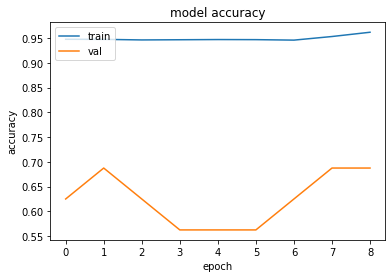

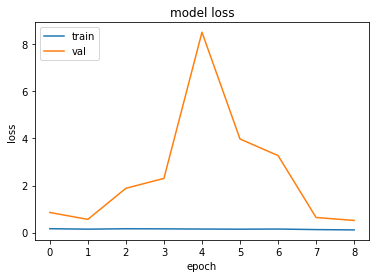

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We see the accuracy is around *96%*

In [37]:
print("The test data loss ", model.evaluate(test_generator)[0]*100 , "%")
print("The test date score ", model.evaluate(test_generator)[1]*100 , "%")

  ...
    to  
  ['...']
156/156 [==============================] - ETA: 8s - loss: 0.0870 - accuracy: 1.00 - ETA: 8s - loss: 0.0957 - accuracy: 1.00 - ETA: 7s - loss: 0.6966 - accuracy: 0.95 - ETA: 7s - loss: 0.5973 - accuracy: 0.95 - ETA: 7s - loss: 0.5186 - accuracy: 0.96 - ETA: 8s - loss: 0.7200 - accuracy: 0.94 - ETA: 7s - loss: 0.6039 - accuracy: 0.95 - ETA: 7s - loss: 0.5579 - accuracy: 0.95 - ETA: 7s - loss: 0.4945 - accuracy: 0.96 - ETA: 7s - loss: 0.4758 - accuracy: 0.96 - ETA: 7s - loss: 0.4633 - accuracy: 0.95 - ETA: 7s - loss: 0.4180 - accuracy: 0.95 - ETA: 7s - loss: 0.4077 - accuracy: 0.96 - ETA: 6s - loss: 0.5471 - accuracy: 0.94 - ETA: 6s - loss: 0.5041 - accuracy: 0.94 - ETA: 6s - loss: 0.4849 - accuracy: 0.94 - ETA: 6s - loss: 0.4666 - accuracy: 0.95 - ETA: 6s - loss: 0.4397 - accuracy: 0.94 - ETA: 6s - loss: 0.4260 - accuracy: 0.94 - ETA: 6s - loss: 0.3991 - accuracy: 0.95 - ETA: 6s - loss: 0.3756 - accuracy: 0.95 - ETA: 6s - loss: 0.3553 - accuracy: 0.95 - ETA: 6s 

156/156 [==============================] - ETA: 8s - loss: 0.0870 - accuracy: 1.00 - ETA: 8s - loss: 0.0957 - accuracy: 1.00 - ETA: 7s - loss: 0.6966 - accuracy: 0.95 - ETA: 7s - loss: 0.5973 - accuracy: 0.95 - ETA: 7s - loss: 0.5186 - accuracy: 0.96 - ETA: 7s - loss: 0.7200 - accuracy: 0.94 - ETA: 7s - loss: 0.6039 - accuracy: 0.95 - ETA: 7s - loss: 0.5203 - accuracy: 0.96 - ETA: 7s - loss: 0.4945 - accuracy: 0.96 - ETA: 7s - loss: 0.4758 - accuracy: 0.96 - ETA: 7s - loss: 0.4633 - accuracy: 0.95 - ETA: 7s - loss: 0.4180 - accuracy: 0.95 - ETA: 7s - loss: 0.4077 - accuracy: 0.96 - ETA: 6s - loss: 0.5471 - accuracy: 0.94 - ETA: 6s - loss: 0.5041 - accuracy: 0.94 - ETA: 6s - loss: 0.4849 - accuracy: 0.94 - ETA: 6s - loss: 0.4666 - accuracy: 0.95 - ETA: 6s - loss: 0.4397 - accuracy: 0.94 - ETA: 6s - loss: 0.4260 - accuracy: 0.94 - ETA: 6s - loss: 0.3991 - accuracy: 0.95 - ETA: 6s - loss: 0.3756 - accuracy: 0.95 - ETA: 6s - loss: 0.3553 - accuracy: 0.95 - ETA: 5s - loss: 0.3381 - accuracy

The test accuracy is also around 92% so we can conclude that there is not much of a overfitting in our model.

In [57]:
preds = model.predict_generator(test_generator)
preds = np.argmax(preds, axis=-1)

# Original labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(y_true.shape)
print(preds.shape)

(624,)
(624,)


In [58]:
report = classification_report(y_true, preds, target_names=class_labels)
print(report) 

C:\Users\avina\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



In [59]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [60]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

We can try to finetune the model to improve the precision score and the test score. There are lot of misclassification in the model and we can try to reduce them by using better layers in CNN or use Depth Wise Convolutions(Xception Networks) which are robust and requires less parameters compared to its counterpart Convolutional Network. We should aim to increase our precision and recall since the data set is heavily imbalanced and accuracy might not be the best metric to judge the model.